In [1]:
import logging
import tempfile, os, sys
import pandas as pd

sys.path.append("src")

In [2]:
data_dir = "temp_data"
working_directory = tempfile.mkdtemp()

In [3]:
aimed_xml = os.path.join(data_dir, "aimed.xml")

In [4]:
aimed_json = os.path.join(working_directory, "aimed.json")

## Convert raw xml to flattened json

In [5]:
from preprocessors.aimed_json_converter import AIMedJsonConverter

In [6]:
AIMedJsonConverter().convert_fromfile(aimed_xml, aimed_json)

In [7]:
df =  pd.read_json(aimed_json)

In [8]:
df.head()

,interacts,text,participant1Id,participant1Offset,participant1Len,participant1Text,participant2Id,participant2Offset,participant2Len,participant2Text,documentId,sentenceId,otherEntities
0,False,Cytokines measurements during IFN-alpha treatm...,AIMed.d0.s5.e0,30,9,IFN-alpha,AIMed.d0.s5.e1,89,4,IL-4,AIMed.d0,AIMed.d0.s5,[]
1,False,Levels of IFN-gamma were slightly increased fo...,AIMed.d0.s6.e0,10,9,IFN-gamma,AIMed.d0.s6.e1,54,9,IFN-alpha,AIMed.d0,AIMed.d0.s6,[]
2,False,In patients with a complete response to IFN-al...,AIMed.d0.s7.e0,40,9,IFN-alpha,AIMed.d0.s7.e1,65,9,IFN-gamma,AIMed.d0,AIMed.d0.s7,"[{'id': 'AIMed.d0.s7.e2', 'charOffset': 109, '..."
3,False,In patients with a complete response to IFN-al...,AIMed.d0.s7.e0,40,9,IFN-alpha,AIMed.d0.s7.e2,109,9,IFN-alpha,AIMed.d0,AIMed.d0.s7,"[{'id': 'AIMed.d0.s7.e1', 'charOffset': 65, 'l..."
4,False,In patients with a complete response to IFN-al...,AIMed.d0.s7.e0,40,9,IFN-alpha,AIMed.d0.s7.e3,186,4,IL-4,AIMed.d0,AIMed.d0.s7,"[{'id': 'AIMed.d0.s7.e1', 'charOffset': 65, 'l..."


In [9]:
df.shape

(5834, 13)

In [10]:
df.interacts.value_counts()

False    4834
True     1000
Name: interacts, dtype: int64

<AxesSubplot:ylabel='interacts'>

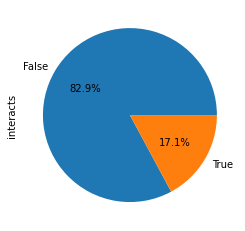

In [11]:
df.interacts.value_counts().plot.pie( autopct='%1.1f%%')